In [182]:
%matplotlib inline

import math
import numpy as np
import cmdstanpy
import pandas as pd
import arviz as az
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from scipy import stats

# Fetch the latest data on the epidemic

In [2]:
curl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
durl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
rurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

confirmed = pd.read_csv(curl, error_bad_lines=False)
dead = pd.read_csv(durl, error_bad_lines=False)
recovered = pd.read_csv(rurl, error_bad_lines=False)

Let's check out some of the earliest data sets.

In [52]:
def subset_country_names(table, countries):
    rose = []
    for country in countries:
        rose.append(confirmed[confirmed['Country/Region'] == country])
    return pd.concat(rose, axis=0)

subset_country_names(confirmed, ['Italy', 'China', 'South Korea'])

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
16,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157
156,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67466,67592,67666,67707,67743,67760,67773,67781,67786,67790
160,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,...,1351,1352,1352,1352,1352,1353,1356,1356,1356,1356
161,Henan,China,33.8820,113.6140,5,5,9,32,83,128,...,1272,1272,1272,1272,1272,1272,1273,1273,1273,1273
162,Zhejiang,China,29.1832,120.0934,10,27,43,62,104,128,...,1215,1215,1215,1215,1215,1215,1215,1215,1215,1227
163,Hunan,China,27.6104,111.7088,4,9,24,43,69,100,...,1018,1018,1018,1018,1018,1018,1018,1018,1018,1018
164,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
165,Jiangxi,China,27.6140,115.7221,2,7,18,18,36,72,...,935,935,935,935,935,935,935,935,935,935
166,Shandong,China,36.3427,118.1498,2,6,15,27,46,75,...,758,758,758,758,758,758,760,760,760,760
168,Jiangsu,China,32.9711,119.4550,1,5,9,18,33,47,...,631,631,631,631,631,631,631,631,631,631


# Modelling one country at a time

## Extracting the time-series values

Here we'll pull out just the measurements we have for the specified country and organize them as a single matrix to feed into Stan.

In [124]:
data_start_index = 4

# data_stop_index = -1

populations = {'Italy':60488135, 'China':1435000000}

def extract_measurements(table, name):
    # Match out the row for the country, get rid of the initial metadata columns
    # and drop any leading or trailing NaN values
    return table.loc[table['Country/Region'] == name].iloc[:, data_start_index:].dropna(axis=1).sum(axis=0)

def form_table(name):
    c0 = extract_measurements(confirmed, name)
    r0 = extract_measurements(recovered, name)
    d0 = extract_measurements(dead, name)
    data = pd.concat([c0, r0, d0], axis=1)
    data.columns = ['Confirmed', 'Recovered', 'Dead']
    return data

In [125]:
country = 'China'

In [126]:
measurements = form_table(country)
day_count = measurements.shape[0]

It's always a good idea to take a look at the data we plan to fit to.

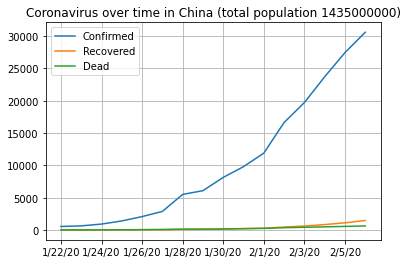

In [127]:
def display_measurements(measurements, name):
    title=f'Coronavirus over time in {name} (total population {populations[name]})'
    measurements.plot(grid=True,
                      title=title)
    
display_measurements(measurements, country)

If you plot an early country, you can clearly see the inflection point at which the behavior change caused an inflection point in infections.

## MCMC sampling

The first step is to arrange the data plus a bit of metadata information for the model so that we can pass it to Stan.

In [139]:
fit_data = {
    'y':measurements.to_numpy(),
    'T':day_count,
    'ts':list(range(0, day_count)),
    'population':populations[country],
}

Now kick off the sampler.  Note the options commented below.

In [150]:
model = cmdstanpy.CmdStanModel(stan_file='sird_reduced.stan')
fit = model.sample(data=fit_data, output_dir='.',
                   # Use a fixed seed so that our runs are deterministic.
                   seed=2222,
                   # This computer has 8 processors, 6 chains is fine
                   chains=6,
                   # Make the sampler a bit more robust in exchange for more sampling time
                   # adapt_delta=0.82,
                   # Let the sampler explore deeper
                   # max_treedepth=10,
                   # Make sure to get enough samples to avoid any diagnostic problems
                   iter_sampling=500)

INFO:cmdstanpy:compiling stan program, exe file: /home/peddie/programming/covid19-modelling/sird_reduced
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 5
INFO:cmdstanpy:finish chain 6


### Check the run

We'll pull up a few initial diagnostics.  If any warnings show up here, we should probably change the run parameters and resample.

In [160]:
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-1.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-2.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-3.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-4.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-5.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-6.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


Processing csv files: /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-1.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-2.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-3.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-4.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-5.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003151938-6.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


In [161]:
fit.summary().loc[('lp__', 'beta', 'gamma', 'zeta', 'sigma'), :]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-364.860000,0.039844,1.391180,-367.531000,-364.573000,-363.214000,1219.14,269.654,1.001940
beta,0.305626,0.000169,0.006381,0.296003,0.305156,0.317123,1419.48,313.967,1.002250
gamma,0.020375,0.000139,0.005320,0.012736,0.019856,0.030044,1461.04,323.158,1.001840
zeta,0.006445,0.000074,0.003193,0.002744,0.005787,0.012633,1867.12,412.978,1.000390
sigma,1627.740000,3.878750,171.826000,1359.920000,1613.200000,1923.170000,1962.43,434.058,0.999902


## Visualizing the posterior

First we would like to be able to pull out the time series data from the MCMC results.

In [162]:
def get_sample_time_series(fit):
    yhat_indices = tuple([x.startswith('y_hat') for x in fit.column_names])
    yhat_samples = fit.sample[:, :, yhat_indices]
    assert(yhat_samples.shape[2] == day_count * 3)
    yhat_samples = yhat_samples.reshape((yhat_samples.shape[0] * yhat_samples.shape[1], 3, day_count))

    return yhat_samples

Next we will plot the time series observations overlaid on the posterior distribution from our MCMC analysis.

In [163]:
def plot_dist_time_series(axis, days, obs, means, stddevs, label):
    axis.fill_between(range(0, days),
                      means - 3 * stddevs, means + 3 * stddevs,
                      label=f'{label} 3-σ', color='#f0e0e0')
    axis.fill_between(range(0, days),
                      means - stddevs, means + stddevs,
                      label=f'{label} 1-σ', color='#e0d0d0')
    axis.plot(range(0, days), means,
              label=f'{label} mean')
    axis.plot(range(0, days), obs,
              label=f'Recorded {label}',
              marker='D', linewidth=0.8)
    plt.setp(axis.get_xticklabels(), visible=False)

    axis.grid(True)
    axis.set_ylabel(f'Number of {label} cases')
    axis.legend()
    
def plot_posterior_time_series(samples, meas, name):
    sample_mean = np.mean(samples, axis=0)
    sample_std = np.std(samples, axis=0)
    days = samples.shape[2]
    
    fig = plt.figure(figsize=(15, 10))
    fig.set_tight_layout(True)
    gs = gridspec.GridSpec(3, 1)
    fig.suptitle(f'Coronavirus epidemic in {name}')
    
    last_axis = plt.subplot(gs[-1])
    plot_dist_time_series(plt.subplot(gs[0], sharex=last_axis), days,
                          meas.to_numpy()[:, 0],
                          sample_mean[0, :],
                          sample_std[0, :],
                          'Confirmed')
    plot_dist_time_series(plt.subplot(gs[1], sharex=last_axis), days,
                          meas.to_numpy()[:, 1],
                          sample_mean[1, :],
                          sample_std[1, :],
                          'Recovered')
    plot_dist_time_series(last_axis, days,
                          meas.to_numpy()[:, 2],
                          sample_mean[2, :],
                          sample_std[2, :],
                          'Dead')
    plt.setp(last_axis.get_xticklabels(), visible=True)
    last_axis.set_xlabel(f'Day of epidemic')

    plt.tight_layout()
    plt.show()

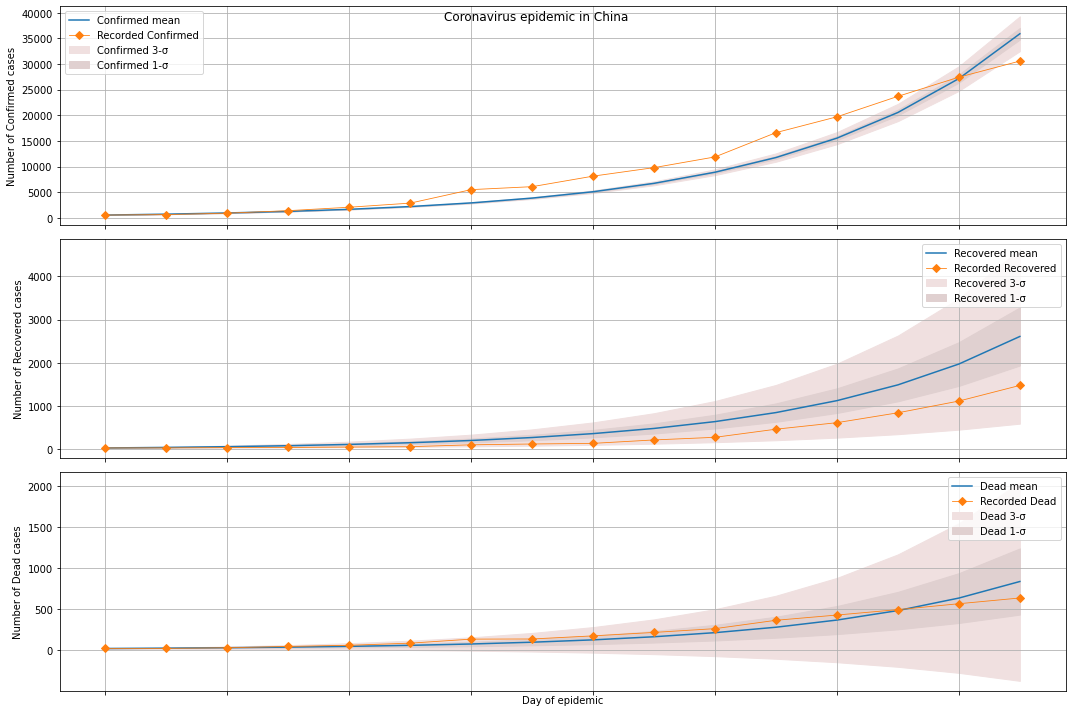

In [164]:
yhat_samples = get_sample_time_series(fit)
plot_posterior_time_series(yhat_samples, measurements, country)

### Error / likelihood analyses

We can look at the likelihood of the final data given the posterior distribution of parameters and the RMS error between our modelled mean value and the observations.

In [210]:
def data_likelihood_from_fit(fit):
    results = fit.get_drawset()
    indices = tuple([x for x in fit.column_names if x.startswith('log_likelihood')])
    results.loc[:, indices].sum(axis=1)

# TODO(MP): understand this
data_likelihood_from_fit(fit)

0      -424.18945
1      -423.07220
2      -421.93572
3      -423.26296
4      -422.42263
          ...    
2995   -423.34793
2996   -423.66541
2997   -423.17930
2998   -422.98911
2999   -422.68249
Length: 3000, dtype: float64


## Extended diagnostics

We'll use arviz to do some more diagnostic plots.

In [165]:
inferred = az.from_cmdstanpy(fit, log_likelihood='log_likelihood')

# TODO(MP): how do you plot log probability of the sample?  'lp__' is gone.
analysis_variables=['beta', 'gamma', 'zeta', 'sigma']

### Effective sample size

We don't have any low effective sample sizes.

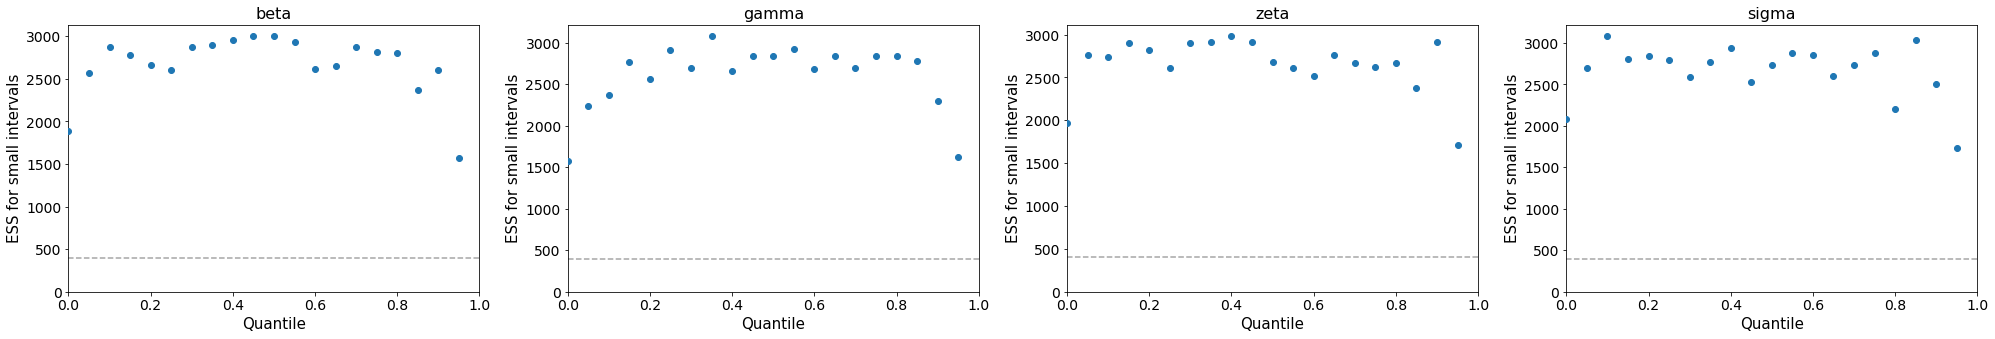

In [166]:
_ = az.plot_ess(inferred, var_names=analysis_variables)

### Posterior correlation plots

What is going on with gamma and beta?

/home/peddie/.local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


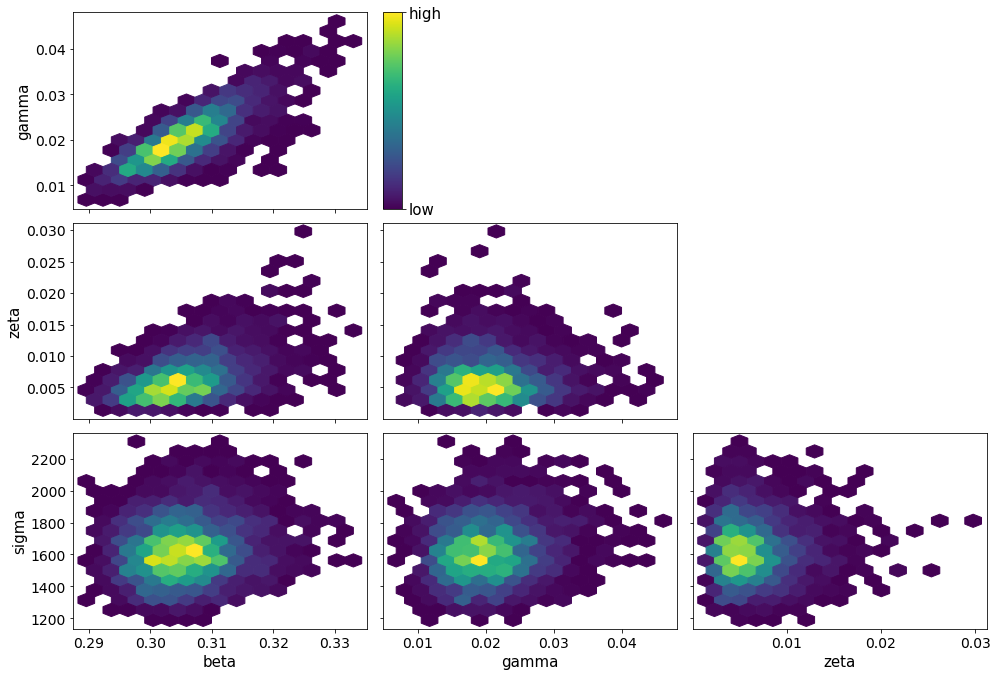

In [167]:
_ = az.plot_pair(inferred, var_names=analysis_variables,
                 kind='hexbin', colorbar=True, divergences=True)

### Leave-one-out analysis

Let's use the prepacked LOO analysis from Stan, provided here by arviz.

In [168]:
loo = az.loo(inferred, pointwise=True)
# loo.pareto_k
loo

/home/peddie/.local/lib/python3.8/site-packages/arviz/stats/stats.py:531: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 3000 by 48 log-likelihood matrix

         Estimate       SE
elpd_loo  -430.32    12.54
p_loo       10.44        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       45   93.8%
 (0.5, 0.7]   (ok)          2    4.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1    2.1%

No idea what this standard error value means yet, but the diagnostics look OK (i.e. we didn't get any warnings about the pareto values getting out of the "ok" region).  Also, puzzlingly ~10 parameters?

In [ ]:
loo_pit = az.loo_pit(inferred)
loo_pit

In [ ]:
_ = az.plot_loo_pit(inferred)